In [139]:
import re
from konlpy.tag import Kkma, Hannanum, Twitter
import string
kkma = Kkma()
hannanum = Hannanum()
twitter = Twitter()

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
remove_quotes_map = dict([(ord(x), " ") for x in ".․,‘’´“”·‧<>「」–-()~…"]) 

def clean_title(title):
    # Remove punctuation and quotes
    title = title.translate(remove_punct_map)
    title = title.translate(remove_quotes_map)
    # Collapse double spaces
    title = re.sub('\s+', ' ', title)
    return title

badwords = "수 년 등 및 몇 중 네이버 뉴스".split()
badwords += "공급 설치 조성 운영 설립 확대 건설 제공 사업 실시 지원 검토 육성 추진 유치 강화 개선 구축 마련 확충 실시 개선 해소".split()
badwords = set(badwords)

def filter_words(nouns):
    # Remove words with digits
    nouns = filter(lambda word: not any(char.isdigit() for char in word), nouns)
    # Remove blacklisted words
    nouns = filter(lambda word: word not in badwords, nouns)
    return list(nouns)

def title2nouns(title):
    return filter_words(kkma.nouns(clean_title(title)))

def title_to_tagged_nouns(title):
    tags = twitter.pos(clean_title(title), norm=True, stem=True)
    # Remove stop words
    tags = filter(lambda tag: tag[0] not in badwords, tags)
    # Keep only Noun and Verb
    tags = filter(lambda tag: tag[1] in ('Noun', 'Verb',), tags)
    return ['/'.join(tag) for tag in tags]
    #return [tag[0] for tag in tags]

def title2list(title):
    """Gather important nouns from a Korean text"""
    title = clean_title(title)
    titlewords = title.strip().split()

    nouns = []
    
    # Add special words
    if any(word != "대로" and word.endswith("대로") for word in titlewords):
        nouns.append("대로")
    if any(word != "도로" and word.endswith("도로") for word in titlewords):
        nouns.append("도로")

    # Gather relevant nouns from twitter and hannanum corpus
    for aword in titlewords:
        tlist = twitter.nouns(aword)
        hlist = hannanum.nouns(aword)
        htlist = list(set(hlist) - set(tlist))  # only in Hannanum
        thlist = list(set(tlist) - set(hlist))  # only in Twitter
        ilist = list(set(hlist) & set(tlist))   # in both
        
        # Add nouns that occur in both corpus
        nouns = nouns + ilist

        # Add all nouns from Twitter corpus that are long enough
        nouns = nouns + list(filter(lambda word: len(word) > 1, thlist))

        # Add nouns from Hannanum corpus that are non divisible (root noun)
        for htword in htlist:
            if len(htword) > 2:
                newlist = twitter.nouns(htword)
                if len(newlist) < 2:
                    nouns.append(htword)

    nouns = filter_words(nouns)
    return list(set(list(nouns)))

In [162]:
title = '신혼부부‧학생‧일인가구 등 수요대응형 주택공급 및 임대주택 지속 공급'
title = ' 임대주택 등록하면 세금·건보료 감면…2020년 등록 의무화 검토'
title = '비정규직의 정규직화 차질 없는 추진'
title = '주택임대 표준계약서 의무사용 법제화 건의'

#print(hannanum.pos(clean_title(title), ntags=22))
#print(['/'.join(tag) for tag in twitter.pos(clean_title(title), norm=True, stem=True)])

print(hannanum.nouns(clean_title(title)))
print(twitter.nouns(clean_title(title)))
print(kkma.morphs(clean_title(title)))
print(title_to_tagged_nouns(title))
print(twitter.pos('전용면적 30~60m² 소형주택 20만호 공급 지원'))

['주택임대', '표준계약서', '의무사용', '법제화', '건의']
['주택', '임대', '표준', '계약서', '의무', '사용', '법', '제화', '건의']
['주택', '임대', '표준', '계약서', '의무', '사용', '법', '제화', '건의']
['주택/Noun', '임대/Noun', '표준/Noun', '계약서/Noun', '의무/Noun', '사용/Noun', '법/Noun', '제화/Noun', '건의/Noun']
[('전용', 'Noun'), ('면적', 'Noun'), ('30', 'Number'), ('~', 'Punctuation'), ('60', 'Number'), ('m', 'Alpha'), ('²', 'Foreign'), ('소형', 'Noun'), ('주택', 'Noun'), ('20', 'Number'), ('만호', 'Noun'), ('공급', 'Noun'), ('지원', 'Noun')]


In [141]:
import json

all_promises = []

with open('jisa_tagged.json') as data_file:    
    data = json.load(data_file)
    i = 0
    for voting_district in data:
        promises = voting_district['promises']
        loc = voting_district['city'] + str(voting_district['district'])
        for p in promises:
            all_promises.append((p['title'], i, ))
            i += 1

In [27]:
from gensim.models.doc2vec import TaggedDocument
import gensim

In [142]:
%%time
class DocIterator(object):
    def __init__(self, data):
        self.data = data

    def __iter__(self):
        for idx, doc in enumerate(self.data):
            tokens = title_to_tagged_nouns(self.data[idx][0])
            labels = [self.data[idx][1]]
            yield TaggedDocument(words=tokens, tags=labels)

documents = list(DocIterator(all_promises))

CPU times: user 4.49 s, sys: 429 ms, total: 4.92 s
Wall time: 4.1 s


In [216]:
"""
from konlpy.corpus import kolaw

def iter_documents(file_ids):
    for fid in file_ids:
        with kolaw.open(fid) as f:
            next(f)
            next(f)
            for line in f:
                yield line

documents = iter_documents(kolaw.fileids())
"""

'\nfrom konlpy.corpus import kolaw\n\ndef iter_documents(file_ids):\n    for fid in file_ids:\n        with kolaw.open(fid) as f:\n            next(f)\n            next(f)\n            for line in f:\n                yield line\n\ndocuments = iter_documents(kolaw.fileids())\n'

In [167]:
%%time
from random import shuffle

alpha, min_alpha, epochs = 0.01, 0.0001, 10
alpha_dec = (alpha-min_alpha) / epochs

shuffle(documents)

model = gensim.models.Doc2Vec(size=16, window=100, min_count=1, workers=8, alpha=alpha, min_alpha=min_alpha, iter=epochs)
model.build_vocab(documents)

model.train(documents, total_examples=model.corpus_count, epochs=model.iter)

"""
for epoch in range(epochs):
    model.train(documents, total_examples=model.corpus_count, epochs=1)
    model.alpha -= alpha_dec
    model.min_alpha = model.alpha
"""

CPU times: user 1.42 s, sys: 558 ms, total: 1.98 s
Wall time: 1.89 s


In [168]:
model.wv.most_similar('주택/Noun', topn=10)

[('화성시/Noun', 0.7863796949386597),
 ('석회/Noun', 0.7693943977355957),
 ('의회/Noun', 0.7685569524765015),
 ('비만/Noun', 0.7662465572357178),
 ('사각/Noun', 0.7214806079864502),
 ('논/Noun', 0.7174060940742493),
 ('초미세먼지/Noun', 0.7125937938690186),
 ('농민/Noun', 0.704876184463501),
 ('생물다양성/Noun', 0.6962452530860901),
 ('예방/Noun', 0.6880587339401245)]

In [161]:
lookup_key = 1155
print("Docs similar to %4d %s" % (lookup_key, all_promises[lookup_key][0]))
for key, score in model.docvecs.most_similar(lookup_key):
    print('%4d %.4f %s (%s)' %(key, score, all_promises[key][0],  ' '.join(title_to_tagged_nouns(all_promises[key][0]))))

Docs similar to 1155 장기공공 임대주택 공급
  84 0.9792 전용면적 30~60m² 소형주택 20만호 공급 지원 (전용/Noun 면적/Noun 소형/Noun 주택/Noun 만호/Noun)
1181 0.9738 시·군으로 권한 이양 (시/Noun 군/Noun 권한/Noun 이양/Noun)
1873 0.9733 진주 부흥 프로젝트 추진 (진주/Noun 부흥/Noun 프로젝트/Noun)
1163 0.9698 중소기업 육성자금 지원 및 신용보증 확대 (중소기업/Noun 자금/Noun 신용/Noun 보증/Noun)
1598 0.9688 신혼부부‧학생‧일인가구 등 수요대응형 주택공급 및 임대주택 지속 공급 (신혼부부/Noun 학생/Noun 일인/Noun 가구/Noun 수요/Noun 대응/Noun 주택/Noun 임대주택/Noun 지속/Noun)
1189 0.9687 장애인 출산비용 및 건강검진 지원 (장애인/Noun 출산/Noun 비용/Noun 건강검진/Noun)
 435 0.9686 1인여성가구 안심택배서비스 지원 (인/Noun 여성/Noun 가구/Noun 안심/Noun 택배/Noun 서비스/Noun)
 861 0.9669 보육의 공공성 강화 (보육/Noun 공공/Noun)
  92 0.9666 세대융합(화합)형 공공주택 공급 (세대/Noun 융합/Noun 화합/Noun 공공/Noun 주택/Noun)
1136 0.9663 노후 주택 녹슨 상수도관 개량 지원 (노후/Noun 주택/Noun 녹슨/Noun 상수/Noun 도관/Noun 개량/Noun)


In [104]:
search = title_to_tagged_nouns(article_parsed['title'])
docvec = model.infer_vector(search)
similar = model.docvecs.most_similar([docvec], topn=5)
print("Most similar to article %s (%s)" % (article_parsed['title'][:50], ' '.join(search)))
for key, score in similar:
    print('%4d %.4f %s (%s)' %(key, score, all_promises[key][0],  ' '.join(title_to_tagged_nouns(all_promises[key][0]))))

Most similar to article 임대주택 등록하면 세금·건보료 감면…2020년 등록 의무화 검토 : 네이버 뉴스 (임대주택/Noun 등록/Noun 하다/Verb 세금/Noun 건/Noun 보료/Noun 감다/Verb 등록/Noun 의무/Noun)
1184 0.5054 어르신 효도세트 지속 추진 (어르신/Noun 효도/Noun 세트/Noun 지속/Noun 추진/Noun)
1885 0.4885 50&50 전략농업육성 (전략/Noun 농업/Noun 육성/Noun)
 477 0.4594 대구광역권 철도망 구축 (대구/Noun 광역권/Noun 철/Noun 도망/Noun 구축/Noun)
 380 0.4470 예술인 창작 안전망 확대 (예술인/Noun 창작/Noun 안전/Noun 망/Noun)
1056 0.4313 노인요양병원 설립 (노인/Noun 요양/Noun 병원/Noun)


In [399]:
model.delete_temporary_training_data()
model.save('model.data')

In [32]:
import requests
article_url = "http://news.naver.com/main/hotissue/read.nhn?mid=hot&sid1=101&cid=957181&iid=2702402&oid=001&aid=0009747960&ptype=052"
api_url = 'https://api.budgetwiser.org/api/news/get_by_url/'
article_parsed = requests.get(api_url, {'url': article_url}).json()

In [257]:
#search = article_parsed['title_keywords'] # text, title, title_keywords
#search = title2nouns(article_parsed['title'])
search = title_to_tagged_nouns(article_parsed['title'])
docvec = model.infer_vector(search)
similar = model.docvecs.most_similar([docvec], topn=5)

In [258]:
print("Most similar to article %s (%s)" % (article_parsed['title'][:50], ' '.join(search)))
for key, score in similar:
    print('%4d %.4f %s (%s)' %(key, score, all_promises[key][0], ' '.join(all_promises[key][1])))

Most similar to article 임대주택 등록하면 세금·건보료 감면…2020년 등록 의무화 검토 : 네이버 뉴스 (임대주택 등록 하다 세금 건 보료 감다 등록 의무 검토)
1643 0.9323 충남 수자원 종합계획 수립으로 안정적인 물 확보 - 친환경 수자원개발로 용수 부족지역의 물 문제 해결 (충남 수자원 종합 계획 수립 안정 물 확보 친환경 수자원 개발 용수 부족 지역 물 문제 해결)
1600 0.9291 평생학습관 설치 운영 (도내미설치지역신축및증설) - 특성화된 평생교육프로그램 보급․지원 (평생 학 습관 도 내미다 지역 신축 증설 특성 되다 평생교육 프로그램 보급 지원)
  22 0.9289 코엑스-한전·서울의료원 부지-잠실 운동장으로 이어지는 국제교류 복합단지 조성사업 추진 (코엑스 한전 서울 의료 부지 잠실 운동장 이어지다 국제 교류 복합 단지 추진)
1527 0.9266 내실있는 전국행사를 통한 관광객 유치 - 2016 전국체전 및 장애인체전, 계룡세계 군사문화축전, 2017 (내다 전국 행사 통한 관광객 유치 전국체전 장애인 체전 계룡 세계 군사 문화 축전)
 120 0.9252 지역 상인·거주민 합의 후, 소규모 보행 전용지구 신청 (지역 상인 거 주민 합의 후 소규모 보행 전용 지구 신청)


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.manifold import TSNE

In [86]:
X = model.docvecs
X = np.reshape(X, (len(model.docvecs), len(model.docvecs[0])))

In [87]:
%%time
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
result = tsne.fit_transform(X) 


CPU times: user 15.9 s, sys: 2.16 s, total: 18.1 s
Wall time: 19.7 s


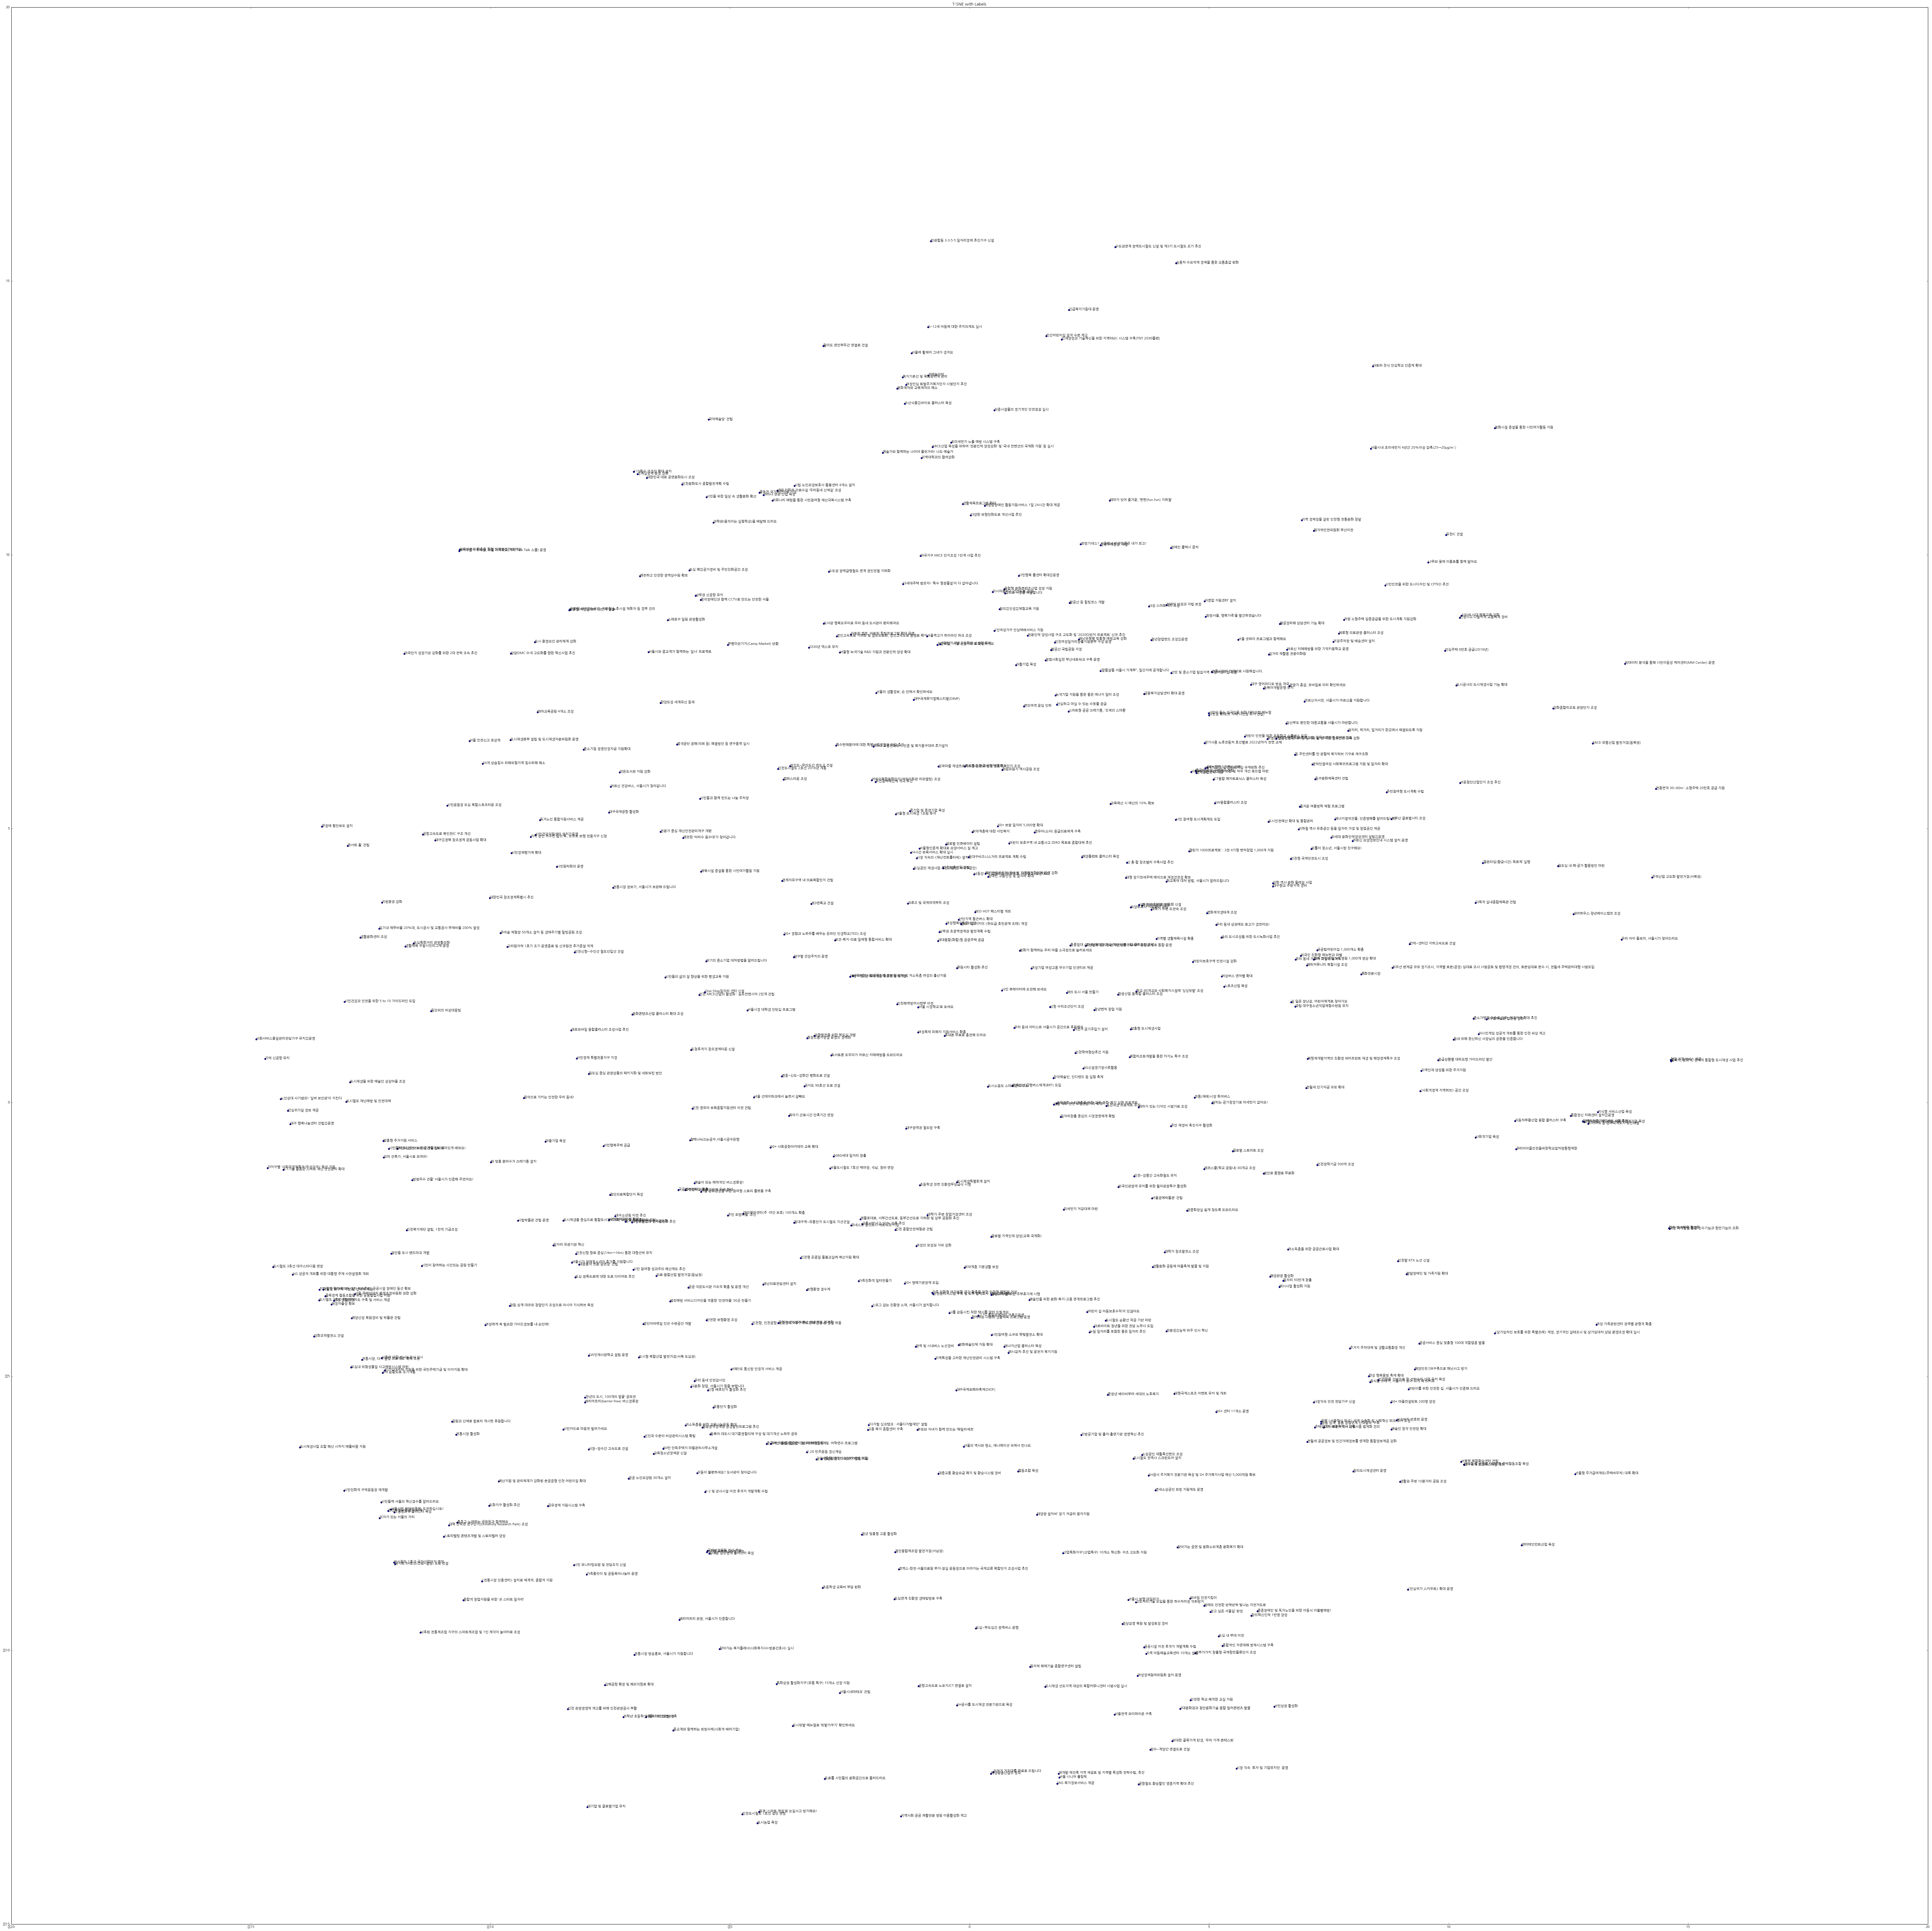

In [88]:
import matplotlib
matplotlib.rc('font', family='NanumGothic')

labels = [doc[0] for doc in all_promises]

#labeled plotting
z=result[:600, 0]
y=result[:600, 1]

fig, ax = plt.subplots(figsize=(100, 100))
ax.scatter(z, y)


for i, txt in enumerate(labels[:600]):
    ax.annotate(txt, (z[i], y[i]))

plt.title("T-SNE with Labels")
plt.show()

In [149]:
len(labels)

2086